Transfer Learning with MobileNetV3

<a name='1'></a>
# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import tensorflow.keras.layers as tfl
from keras.utils import image_dataset_from_directory
import tensorflow_addons as tfa
import plotly.express as px
import plotly.graph_objects as go

from train_utils.callbacks import LRCallBack
from train_utils.models import PercentageModel

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Datasets

In [2]:
BATCH_SIZE = 64
PREFETCH = 2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 9
FEATURES_SHAPE = (960,)
SEED = 1412535
LABELS = [
    'assignments',
    'blurred',
    'chats',
    'food',
    'goodwishes',
    'memes',
    'notices',
    'other',
    'pets',
]

In [3]:
dataset_size = (300, 300)

train_dataset = image_dataset_from_directory(
    'C:\\tensorflow_datasets\\organizo_300x300',
    batch_size=BATCH_SIZE,
    shuffle=True,
    image_size=dataset_size,
    label_mode='categorical',
    validation_split=0.05,
    subset='training',
    seed=SEED,)

cv_dataset = image_dataset_from_directory(
    'C:\\tensorflow_datasets\\organizo_300x300',
    batch_size=BATCH_SIZE,
    shuffle=True,
    image_size=dataset_size,
    label_mode='categorical',
    validation_split=0.05,
    subset='validation',
    seed=SEED,)

DATA_SHAPE = dataset_size + (3,)
BATCHES = tf.data.experimental.cardinality(train_dataset).numpy()
print(BATCHES)

Found 138770 files belonging to 9 classes.
Using 131832 files for training.
Found 138770 files belonging to 9 classes.
Using 6938 files for validation.
2060


## Verify Dataset Integrity

# Preprocess Data

In [4]:
augmenter = tf.keras.Sequential([
    tfl.RandomFlip('horizontal'),
    tfl.RandomTranslation(0.1, 0.1),
    tfl.RandomZoom((-0.1, 0)),
    tfl.RandomContrast(0.5),
    tfl.RandomBrightness(0.5),
    tfl.Resizing(IMG_SHAPE[1], IMG_SHAPE[0])
])

train_dataset = train_dataset.map(
    lambda x, y: (augmenter(x), y),
    num_parallel_calls=PREFETCH
).shuffle(
    32, reshuffle_each_iteration=True
).prefetch(buffer_size=PREFETCH)

cv_dataset = cv_dataset.map(
    lambda x, y: (tfl.Resizing(IMG_SHAPE[1], IMG_SHAPE[0])(x), y),
    num_parallel_calls=PREFETCH
)

# Hyper-Parameters

In [3]:
## 0 to skip
GRADIENT_CLIP = 1e2    # [5, 100]
FIXED_LAYERS = 0       # [0, 276]
LR = (-3,-6)          # [-3, -6]
EPOCHS = 10            # [0, 30]
ALPHA = 0.75
BETA = 0.5             # (0, 1)
L2 = 1e-4                 # [-3, -6]
DROPOUT = 0.3

In [4]:
def mobilenet_model():
    model = tf.keras.applications.MobileNetV3Small(
        input_shape=IMG_SHAPE,
        include_top=False,
        alpha=ALPHA,
        dropout_rate=DROPOUT,
        pooling='avg',)
    model.trainable = True
    for layer in model.layers[:FIXED_LAYERS]:
        layer.trainable = False
    return model

def top_model(input_shape):
    inputs = tf.keras.Input(
        name='Input',
        shape=input_shape,)
    x = inputs
    
    x = tfl.Dense(
        units=NUM_CLASSES,
        name='Dense_0',
        kernel_regularizer=keras.regularizers.L2(L2),
        activation='softmax',)(x)
    
    outputs = x
    model = tf.keras.Model(
        inputs,
        outputs,
        name='Top')
    
    return model


def train_models():
    img_input = tf.keras.Input(
        name='ImageInput',
        shape=IMG_SHAPE)
    
    x = img_input
    x = mobilenet_model()(x)
    
    top = top_model(x.shape[1:])
    x = top(x)
    
    outputs = x
    model = PercentageModel(
                img_input,
                outputs,
                name='full',)
    return model

# Define Metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(global_clipnorm=GRADIENT_CLIP)

metrics = [
    tfa.metrics.FBetaScore(
        num_classes=NUM_CLASSES,
        average='macro',
        beta=0.1,
        threshold=BETA,
        name='F0.1',),
    tf.keras.metrics.Precision(
        thresholds=BETA,
        name='pre',),
    tf.keras.metrics.Recall(
        thresholds=BETA,
        name='rec',),]


model = train_models()
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=metrics,
    weighted_metrics=[],
    run_eagerly=False,)
print(model.summary())

# print('Total Flops:', get_flops(model, batch_size=BATCH_SIZE) // 2)

from train_utils.memory import keras_model_memory_usage_in_mbs

print(keras_model_memory_usage_in_mbs(model, batch_size=BATCH_SIZE))

Model: "full"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 432)              583160    
 l)                                                              
                                                                 
 Top (Functional)            (None, 9)                 3897      
                                                                 
Total params: 587,057
Trainable params: 577,377
Non-trainable params: 9,680
_________________________________________________________________
None
1842


# Train

In [8]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(
    metrics_separator=' | ',
    epoch_bar_format='{n_fmt}/{total_fmt} | ETA: {remaining} | Elapsed: {elapsed} {bar} {desc}',
    metrics_format='{name}: {value:0.2f}%',
    update_per_second=1,)

lr_callback = LRCallBack(epochs=EPOCHS, batches=BATCHES, l_r=LR)

history = model.fit(
    train_dataset,
    validation_data=cv_dataset,
    epochs=lr_callback.epochs,
    verbose=0,
    initial_epoch=0,
    callbacks=[tqdm_callback, lr_callback],)

Training:   0%|                                             0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.001000
Epoch 2/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000464
Epoch 3/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000215
Epoch 4/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000100
Epoch 5/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000046
Epoch 6/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000022
Epoch 7/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000010
Epoch 8/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000005
Epoch 9/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000002
Epoch 10/10


0/2060 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000001


## Extended Training

# Plot the training and validation accuracy:

[0.00000000e+00 1.00004954e+00 2.00009907e+00 ... 2.01859999e+04
 2.01870000e+04 2.01880000e+04]


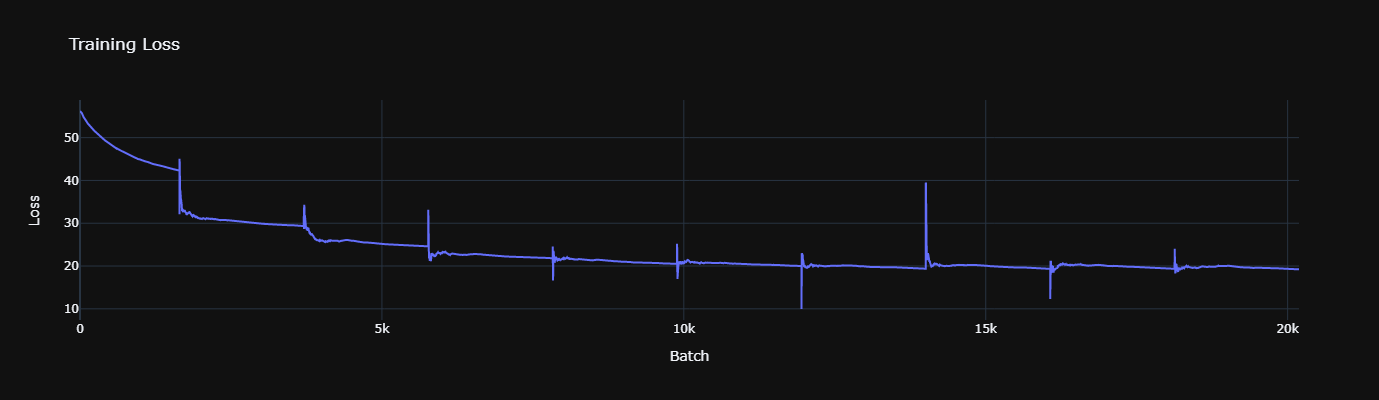

In [9]:
y = lr_callback.batch_losses[int(BATCHES*0.2):]
x = np.linspace(0, len(y), len(y))
print(x)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode='lines',
        name='Loss',
    )
)
fig.update_layout(
    template='plotly_dark', 
    height=400, width=1500, 
    title_text='Training Loss',
    xaxis_title='Batch',
    yaxis_title='Loss',
)
fig.show()

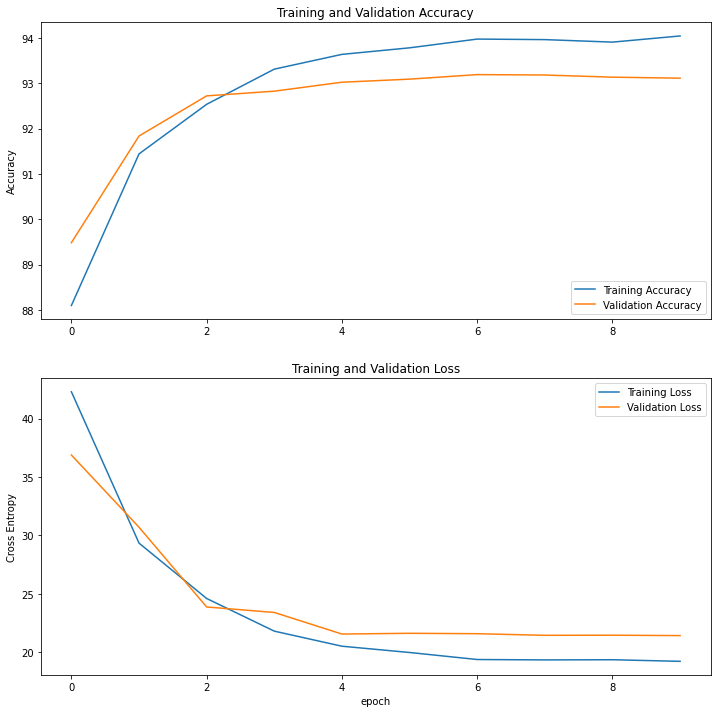

In [10]:
acc = history.history['F0.1']
val_acc = history.history['val_F0.1']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0,100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,100])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Compute Threshold

In [ ]:
res = 21
x = np.linspace(0.4, 0.9, res, endpoint=True)
yf = np.zeros(res)
yr = np.zeros(res)
yp = np.zeros(res)

tqdm_callback = tfa.callbacks.TQDMProgressBar(
    metrics_separator=' | ',
    epoch_bar_format='{n_fmt}/{total_fmt} | ETA: {remaining} | Elapsed: {elapsed} {bar} {desc}',
    metrics_format='{name}: {value:0.2f}%',
    update_per_second=1,)

for i in range(res):
    beta = x[i]
    print(f'threshold = {beta}')
    metrics = [
        tfa.metrics.FBetaScore(
            num_classes=NUM_CLASSES,
            average='weighted',
            beta=0.1,
            threshold=beta,
            name='Fbeta',),
        tf.keras.metrics.Precision(
            thresholds=beta,
            name='pre',),
        tf.keras.metrics.Recall(
            thresholds=beta,
            name='rec',),]
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics,
        weighted_metrics=[],
        run_eagerly=True,
    )
    result = model.evaluate(
        cv_dataset, 
        verbose=0, 
        return_dict=True,
        callbacks=[tqdm_callback],)
    yf[i] = result['Fbeta']
    yr[i] = result['rec']
    yp[i] = result['pre']

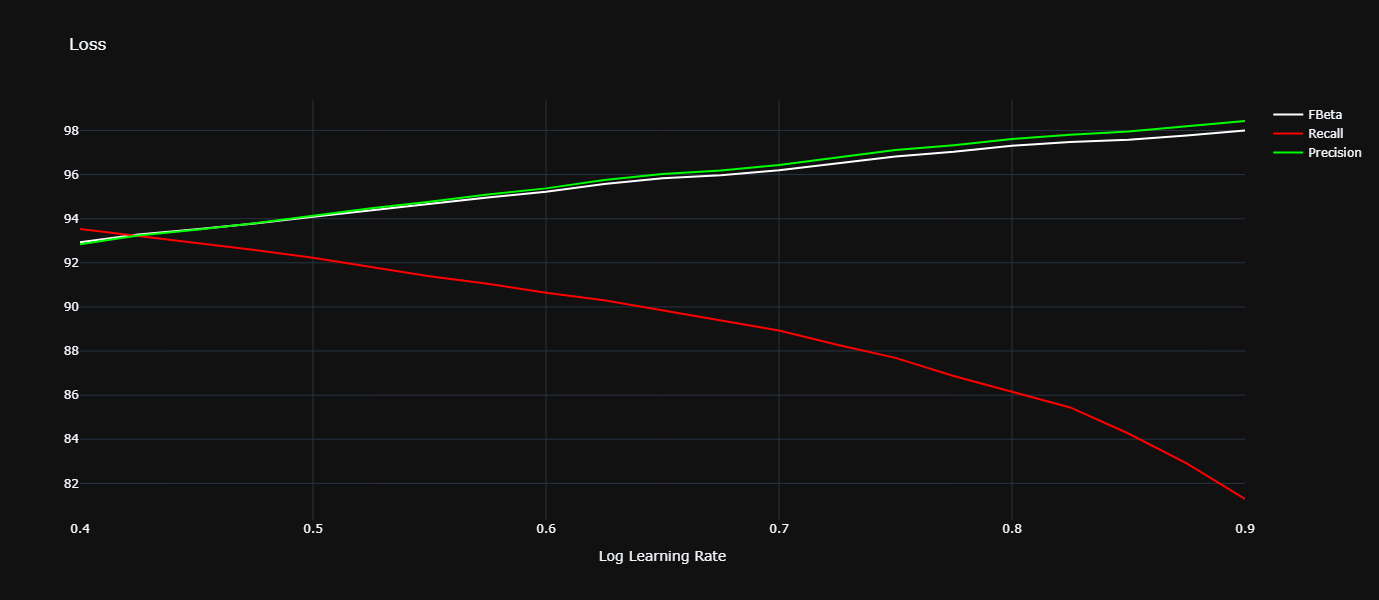

In [12]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x, 
        y=yf,
        mode='lines',
        name='FBeta',
        line_color="#fff"
    )
)
fig.add_trace(
    go.Scatter(
        x=x, 
        y=yr,
        mode='lines',
        name='Recall',
        line_color="#f00"
    )
)
fig.add_trace(
    go.Scatter(
        x=x, 
        y=yp,
        mode='lines',
        name='Precision',
        line_color="#0f0"
    )
)
fig.update_layout(
    template='plotly_dark', 
    height=600, width=1000, 
    title_text='Loss',
    xaxis_title='Threshold',
    yaxis_title='',
)
fig.show()

# Category Wise Metrics

In [12]:
BETA = 0.65
print(f'threshold = {BETA}')
metrics = []
for i, name in enumerate(LABELS):
    metrics = [
        tf.keras.metrics.Precision(
            thresholds=BETA,
            class_id=i,
            name='pre',),
        tf.keras.metrics.Recall(
            thresholds=BETA,
            class_id=i,
            name='rec',),]
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics,
        weighted_metrics=[],
        run_eagerly=True,
    )
    result = model.evaluate(
        cv_dataset, 
        verbose=0, 
        return_dict=True,
        callbacks=[],)
    result['category'] = name
    del result['loss']
    metrics += [result]
    print(result)

threshold = 0.65
{'pre': 99.85272216796875, 'rec': 96.85713958740234, 'category': 'assignments'}
{'pre': 100.0, 'rec': 95.65217590332031, 'category': 'blurred'}
{'pre': 98.05447387695312, 'rec': 97.17223358154297, 'category': 'chats'}
{'pre': 96.6887435913086, 'rec': 83.90804290771484, 'category': 'food'}
{'pre': 95.04875946044922, 'rec': 90.2421646118164, 'category': 'goodwishes'}
{'pre': 94.56365966796875, 'rec': 86.68852233886719, 'category': 'memes'}
{'pre': 94.11764526367188, 'rec': 90.85173797607422, 'category': 'notices'}
{'pre': 86.16352081298828, 'rec': 67.99007415771484, 'category': 'other'}
{'pre': 93.9262466430664, 'rec': 87.12274169921875, 'category': 'pets'}


## Examine False Positives

In [14]:
val = iter(cv_dataset)

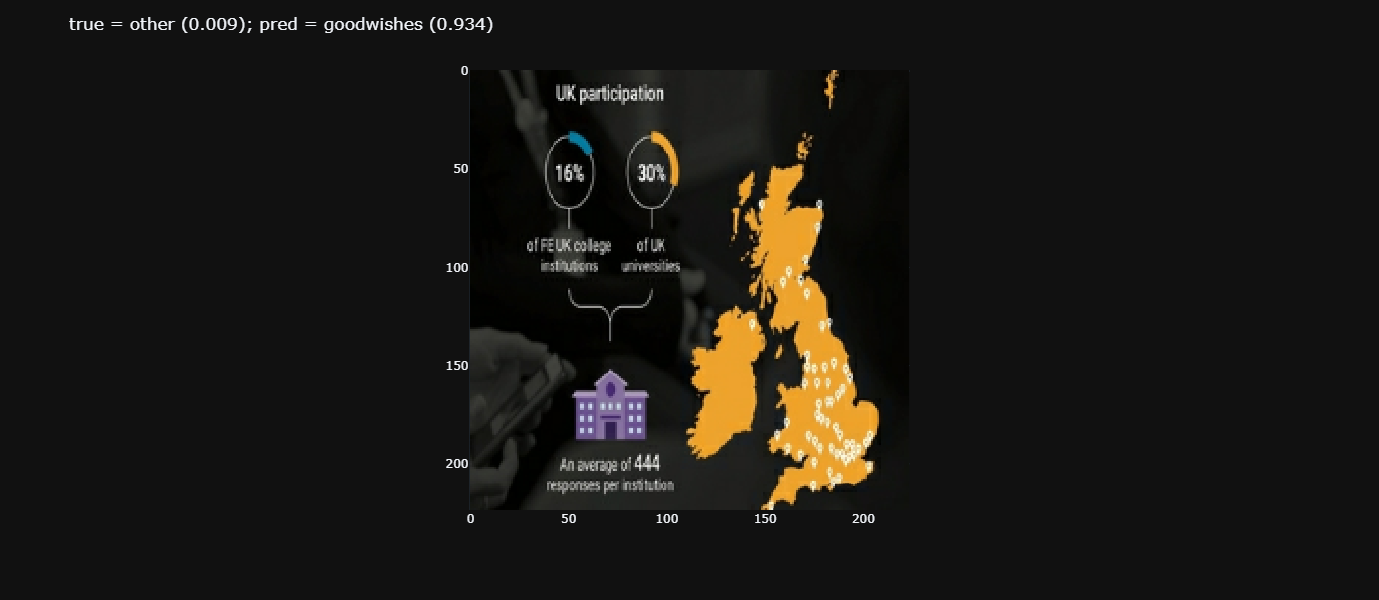

In [22]:
BETA = 0.90
found = False
while not found:
    x, y = next(val)
    out = model(x)
    truth = tf.math.argmax(y, axis=-1).numpy()
    pred = tf.math.argmax(out, axis=-1).numpy()
    for i, l in enumerate(pred):
        t = truth[i]
        if out[i, l] >= BETA and l != t:
            fig = px.imshow(x[i].numpy())
            fig.update_layout(
                template='plotly_dark', 
                height=600, width=600, 
                title_text='true = %s (%.3f); pred = %s (%.3f)' % (LABELS[t], out[i, t], LABELS[l], out[i, l]))
            fig.show()
            found = True
            break

# Test Model Predictions

In [7]:
from PIL import Image

In [8]:
CATEGORY_THRESHOLD = 0.65

In [13]:
model = tf.saved_model.load('models\\category\\category_model')

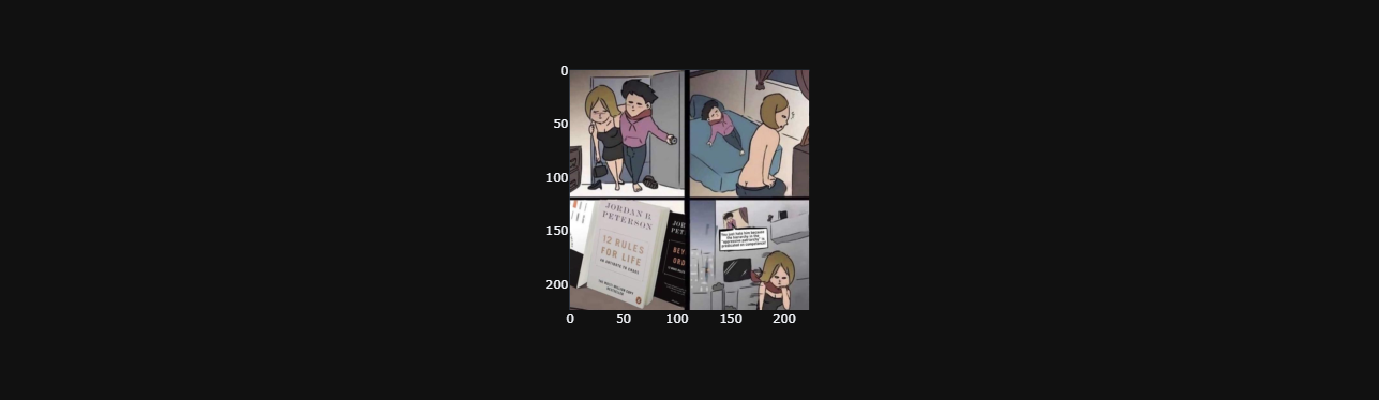

category =  ('memes', 0.99828005)


In [17]:
img = Image.open(r"C:\Users\arlak\Downloads\95fh0h29pw991.jpg")
img = img.resize((224, 224), Image.Resampling.BILINEAR).convert('RGB')

fig = px.imshow(img)
fig.update_layout(
    template='plotly_dark', 
    height=400, width=400,)
fig.show()

inp = tf.constant(img, dtype='float32')

output = model(inp[None, ...])[0]
categories_p = output

category = ("other", 1.0)
for i, p in enumerate(categories_p.numpy()):
    if p >= CATEGORY_THRESHOLD:
        category = (LABELS[i], p)
print('category = ', category)

# Save the model

In [19]:
_saved_model_dir = 'models\\category\\category_model'

In [ ]:
model.save(f'models\\categories\\complete.h5')
model.save_weights(f'models\\categories\\complete_weights.h5')
tf.saved_model.save(model, _saved_model_dir)

INFO:tensorflow:Assets written to: models\category\category_model\assets


INFO:tensorflow:Assets written to: models\category\category_model\assets


In [21]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(_saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open('models/category/category.tflite', 'wb') as f:
    f.write(tflite_model)

In [24]:
from tflite_support.metadata_writers import image_classifier, writer_utils

writer = image_classifier.MetadataWriter
_MODEL_PATH = 'models/category/category.tflite'
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = 'models/categories/label_names.txt'
_SAVE_TO_PATH = "models/category/category_with_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 0
_INPUT_NORM_STD = 1

# Create the metadata writer.
writer = writer.create_for_inference(
    writer_utils.load_file(_MODEL_PATH),
    [_INPUT_NORM_MEAN], 
    [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  0.0
                ],
                "std": [
                  1.0
                ]
              }
            }
          ],
          "stats": {
            "max": [
              255.0
            ],
            "min": [
              0.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probabil